<a href="https://colab.research.google.com/github/princexoleo/u_net_pattern_lab/blob/master/u_net_segmentation_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dataset Download From Kaggle

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mazleon","key":"363f2f7fd8692add55876ab33f0ad533"}'}

upload kaggle api token

In [0]:
# create a folder where dataset can be stored
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
# change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [20]:
# download datasets
!kaggle competitions download -c data-science-bowl-2018

  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 43.4MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 88.8MB/s]
 55% 5.00M/9.10M [00:01<00:01, 4.03MB/s]
100% 9.10M/9.10M [00:01<00:00, 7.25MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.32MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 206MB/s]
 85% 67.0M/79.1M [00:00<00:00, 47.3MB/s]
100% 79.1M/79.1M [00:00<00:00, 90.6MB/s]
 99% 273M/276M [00:05<00:00, 45.4MB/s]
100% 276M/276M [00:05<00:00, 55.0MB/s]


In [21]:
from zipfile import ZipFile
file_name = "/content/stage1_train.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall("/content/data")
  print('Done')

Done


In [22]:
file_name = "/content/stage1_train_labels.csv.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall("/content/data")
  print('Done')

Done


In [0]:
label_path = "/content/data/stage1_train_labels.csv"


##Nuclei Code Started From here

In [1]:
# import libraries 
import os
import sys
import numpy as np
import random

import cv2
import matplotlib.pyplot as plt
%tensorflow_version 2.0.0
import tensorflow as tf
from tensorflow import keras


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:

print(tf.__version__)

2.2.0-rc2


In [0]:
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator

In [0]:


class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))



##Hyperparameter

In [0]:
batch_size = 8
image_size = 128
epochs = 5
train_path ="/content/data/"

train_ids = next(os.walk(train_path))[1]

val_data_size = 10
valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [46]:
gen = DataGen(train_ids,train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


In [49]:
r = random.randint(0, len(x)-1)
print(r)

6


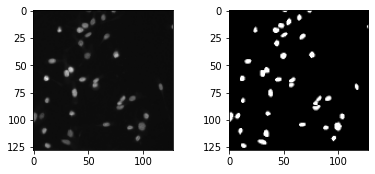

In [50]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

##Diffent Convolutional Blocks

In [0]:
def down_block(x, filters, kernel_size=(3,3), padding='same', strides=1):
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
  p = keras.layers.MaxPool2D((2,2),(2,2))(c)
  return c, p

def up_block(x,skip ,filters, kernel_size=(3,3), padding='same', strides=1):
  us = keras.layers.UpSampling2D((2,2))(x)
  concat = keras.layers.Concatenate()([us,skip])
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(concat)
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
  return c

def bottleneck(x, filters, kernel_size=(3,3), padding='same', strides=1):
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
  c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
  return c


##UNet Model

In [0]:
def UNet():
  f = [16, 32, 64, 128, 256]
  inputs = keras.layers.Input((image_size, image_size, 3))

  p0 = inputs
  c1, p1 = down_block(p0, f[0]) # 128 >> 64
  c2, p2 = down_block(p1,f[1]) # 64 >> 32
  c3, p3 = down_block(p2,f[2]) # 32 >> 16
  c4, p4 = down_block(p3,f[3]) # 16 >> 8

  # bottleneck
  bn = bottleneck(p4, f[4])

  # up sampling
  u1 = up_block(bn, c4, f[3]) # 8 >> 16
  u2 = up_block(u1, c3, f[2]) # 16 >> 32
  u3 = up_block(u2, c2, f[1]) # 16 >> 32
  u4 = up_block(u3, c1, f[0]) # 16 >> 32

  # output layers
  outputs = keras.layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(u4)
  model = keras.models.Model(inputs, outputs)
  return model


Call unet model

In [59]:
model = UNet()
model.compile(optimizer = 'adam', loss="binary_crossentropy", metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_58[0][0]                  
____________________________________________________________________________________________

##Trainig Model

In [63]:
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [66]:
traingen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
validgen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

# checkpoint
filepath="check.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accu', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit(traingen, validation_data=validgen, steps_per_epoch=train_steps,
          validation_steps=valid_steps, epochs=epochs,
          )

Epoch 1/5
82/82 [==============================] - 22s 265ms/step - loss: 0.1989 - acc: 0.8826 - val_loss: 0.1863 - val_acc: 0.9061
Epoch 2/5
82/82 [==============================] - 6s 78ms/step - loss: 0.2355 - acc: 0.9159 - val_loss: 0.3899 - val_acc: 0.7980
Epoch 3/5
69/82 [========================>.....] - ETA: 0s - loss: 0.1711 - acc: 0.9268

UnknownError: ignored

##Testing the model

In [0]:
# Save the Weights
model.save_weights("UNetW.h5")

In [0]:
## Dataset for prediction
x, y = validgen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

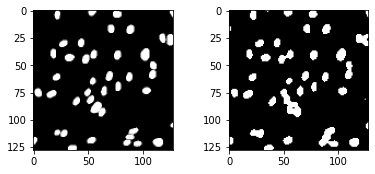

In [70]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

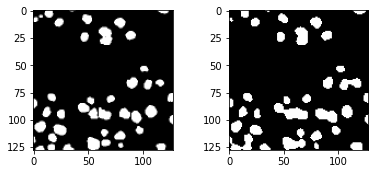

In [71]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")